In [4]:
# pip install scikit-learn joblib pyarrow pandas
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import joblib

In [8]:
df = pd.read_parquet(r"C:\Users\78777199Z\Documents\Estudio\repos\TFM-Deployment\docker\spark\dataset\v8_mlp.parquet", engine="fastparquet")

In [9]:
df.columns
df.head(1)
df.count()

f_0      968979
f_1      968979
f_2      968979
f_3      968979
f_4      968979
f_5      968979
label    968979
dtype: int64

In [10]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


# 2. Features y labels
# selecciona f_0, f_1, ...
feat_cols = [c for c in df.columns if c.startswith("f_")]
X = df[feat_cols].astype("float32").values
y = df["label"].astype("int64").values

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Definir MLP (Adam, ReLU, early stopping)
mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",         # Adam como en el paper
    alpha=1e-4,            # regularización L2
    batch_size=256,
    learning_rate_init=1e-3,
    max_iter=100,
    early_stopping=True,
    validation_fraction=0.1,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)

# 5. Entrenar
mlp.fit(X_train, y_train)

# 6. Evaluar
y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred, average="weighted"))

Iteration 1, loss = 0.07855828
Validation score: 0.982146
Iteration 2, loss = 0.02493437
Validation score: 0.992518
Iteration 3, loss = 0.02088067
Validation score: 0.992724
Iteration 4, loss = 0.01979865
Validation score: 0.992711
Iteration 5, loss = 0.01803644
Validation score: 0.980702
Iteration 6, loss = 0.01842577
Validation score: 0.995949
Iteration 7, loss = 0.01688128
Validation score: 0.994285
Iteration 8, loss = 0.01680391
Validation score: 0.995524
Iteration 9, loss = 0.01615237
Validation score: 0.986674
Iteration 10, loss = 0.01518772
Validation score: 0.994517
Iteration 11, loss = 0.01566707
Validation score: 0.992737
Iteration 12, loss = 0.01499318
Validation score: 0.995627
Iteration 13, loss = 0.01472663
Validation score: 0.997226
Iteration 14, loss = 0.01535540
Validation score: 0.995085
Iteration 15, loss = 0.01434108
Validation score: 0.996065
Iteration 16, loss = 0.01420595
Validation score: 0.996143
Iteration 17, loss = 0.01384070
Validation score: 0.992982
Iterat

In [7]:
import joblib

# Guardar modelo entrenado
joblib.dump(mlp, "mlp_camelot_adam_2.pkl")
print("Modelo guardado en mlp_camelot_adam.pkl")

Modelo guardado en mlp_camelot_adam.pkl


#### Matriz de confusión

              precision    recall  f1-score   support

           0     0.9999    0.9907    0.9952     16479
           1     0.9979    0.9997    0.9988     31798
           2     0.9985    1.0000    0.9993     10246
           3     1.0000    0.9979    0.9989     27488
           4     0.9963    0.9996    0.9979     19719
           5     0.9975    0.9981    0.9978     19685
           6     0.9984    0.9902    0.9943      9021
           7     0.9953    0.9995    0.9974     16252
           8     0.9951    0.9999    0.9975     14231
           9     0.9989    0.9924    0.9957      9361
          10     0.9956    0.9984    0.9970     19516

    accuracy                         0.9976    193796
   macro avg     0.9976    0.9970    0.9973    193796
weighted avg     0.9976    0.9976    0.9976    193796

[[16325     0     0     0     0     0     0    73     0     0    81]
 [    0 31790     0     0     0     2     0     0     0     0     6]
 [    0     0 10246     0     0     0     0     0

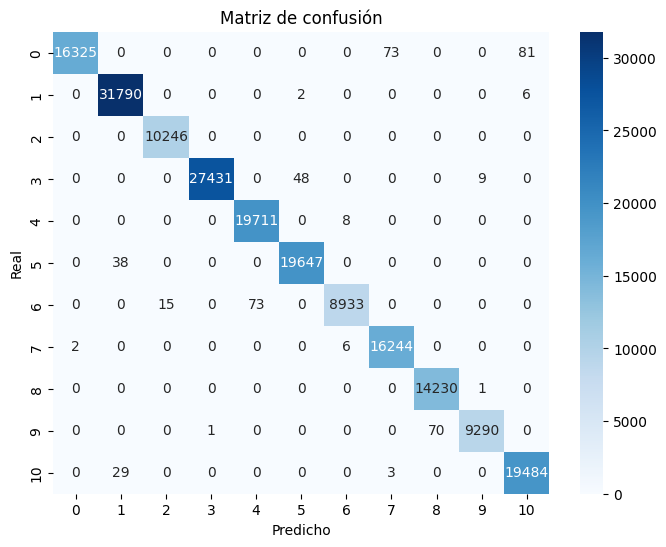

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print(classification_report(y_test, y_pred, digits=4))
cm = confusion_matrix(y_test, y_pred)
print(cm)


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("Matriz de confusión")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

#### Validación cruzada (K-Fold) con 5 folds

In [13]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"acc": "accuracy", "f1w": "f1_weighted"}

cv_res = cross_validate(
    mlp, X, y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1,
    return_train_score=False
)

print(
    f"CV Accuracy: {cv_res['test_acc'].mean():.4f} ± {cv_res['test_acc'].std():.4f}")
print(
    f"CV F1-weighted: {cv_res['test_f1w'].mean():.4f} ± {cv_res['test_f1w'].std():.4f}")

CV Accuracy: 0.9971 ± 0.0003
CV F1-weighted: 0.9971 ± 0.0003


#### Curva de pérdida (y validación si la hay)

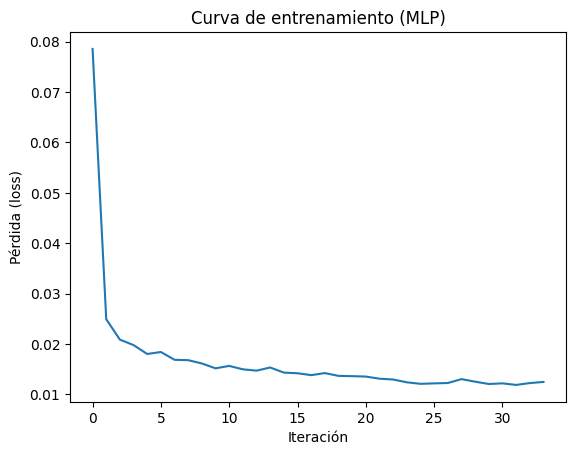

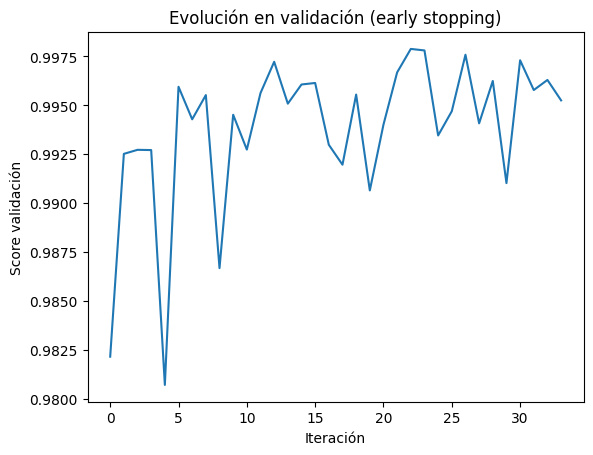

In [15]:
import matplotlib.pyplot as plt

# Pérdida de entrenamiento
plt.figure()
plt.plot(mlp.loss_curve_)
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Curva de entrenamiento (MLP)")
plt.savefig("loss_curve.png", dpi=300, bbox_inches="tight")
plt.show()

# Puntuación en validación si usaste early_stopping=True
if hasattr(mlp, "validation_scores_"):
    plt.figure()
    plt.plot(mlp.validation_scores_)
    plt.xlabel("Iteración")
    plt.ylabel("Score validación")
    plt.title("Evolución en validación (early stopping)")
    plt.savefig("val_curve.png", dpi=300, bbox_inches="tight")
    plt.show()

#### Carga del Modelo

In [ ]:
import joblib
import pandas as pd
import numpy as np

# Cargar modelo
mlp_loaded = joblib.load("mlp_camelot_adam.pkl")

# Cargar nuevas canciones ya con columnas f_0..f_n (mismo pipeline de features)
df_new = pd.read_parquet(
    "/opt/bitnami/spark/datasets/nuevas_canciones_mlp.parquet")
feat_cols = [c for c in df_new.columns if c.startswith("f_")]
X_new = df_new[feat_cols].astype("float32").values

# Predicción
pred_clusters = mlp_loaded.predict(X_new)
probs = mlp_loaded.predict_proba(X_new)   # para Top-C clusters

df_new["pred_cluster"] = pred_clusters
# Top-2 clusters con probas
topC = 2
top2 = np.argpartition(-probs, kth=topC-1, axis=1)[:, :topC]
df_new["topC_clusters"] = [list(row) for row in top2]

In [23]:
import joblib
import numpy as np
import pandas as pd

# ---------- Config ----------
# tu catálogo plano (features + label)
PARQUET_CATALOG = r"C:\Dataset\v8_mlp.parquet"
MODEL_PATH = "mlp_camelot_adam.pkl"
TOP_C = 2          # nº de clusters a expandir (paper-like)
TOP_N = 200        # nº de candidatos iniciales tras coseno
K_FINAL = 50       # tamaño final tras MMR
LAMBDA_REL = 0.7   # trade-off relevancia/diversidad en MMR

# ---------- Utilidades ----------


def feature_columns(df: pd.DataFrame):
    """ Detecta columnas f_0..f_n en orden correcto. """
    return [c for c in df.columns if c.startswith("f_")]


def cosine_sim_matrix(seed_vec: np.ndarray, M: np.ndarray) -> np.ndarray:
    """ Cosine(seed, cada fila de M). """
    seed_norm = np.linalg.norm(seed_vec)
    M_norms = np.linalg.norm(M, axis=1)
    denom = (seed_norm * M_norms)
    denom[denom == 0] = 1e-12
    return (M @ seed_vec) / denom


def mmr_select(seed_vec: np.ndarray, cand_mat: np.ndarray, items_idx: np.ndarray, k=50, lambda_rel=0.7):
    """
    MMR greedy: combina relevancia (cosine con seed) y diversidad
    (máx. similitud con ya seleccionados). Devuelve índices seleccionados en orden.
    """
    selected = []
    selected_idx = []
    if len(items_idx) == 0:
        return selected_idx

    # Pre-calc similitud de relevancia
    rel = cosine_sim_matrix(seed_vec, cand_mat)

    # Escoge el más relevante primero
    best0 = int(np.argmax(rel))
    selected_idx.append(items_idx[best0])
    selected.append(cand_mat[best0])

    # Iterativamente añade con MMR
    while len(selected_idx) < min(k, len(items_idx)):
        best_i, best_score = None, -1e9
        for i in range(len(items_idx)):
            if items_idx[i] in selected_idx:
                continue
            # diversidad: max similitud con ya seleccionados
            max_sim = 0.0
            for s in selected:
                denom = (np.linalg.norm(cand_mat[i]) * np.linalg.norm(s))
                if denom == 0:
                    sim = 0.0
                else:
                    sim = float(np.dot(cand_mat[i], s) / denom)
                if sim > max_sim:
                    max_sim = sim
            score = lambda_rel * rel[i] - (1 - lambda_rel) * max_sim
            if score > best_score:
                best_score = score
                best_i = i
        selected_idx.append(items_idx[best_i])
        selected.append(cand_mat[best_i])
    return selected_idx


# ---------- Cargar modelo y catálogo ----------
mlp = joblib.load(MODEL_PATH)
catalog = pd.read_parquet(PARQUET_CATALOG)
feat_cols = feature_columns(catalog)

# ---------- 1) Seed: usa la "canción inventada" o una real del catálogo ----------
# (A) Canción inventada (misma que arriba)
d = mlp.n_features_in_
rng = np.random.default_rng(123)
seed_vec = rng.normal(0.0, 0.1, size=d).astype("float32")

# (B) Si quieres usar una seed real del catálogo:
# seed_row = catalog.sample(1, random_state=7).iloc[0]
# seed_vec = seed_row[feat_cols].to_numpy(dtype=np.float32)

# ---------- 2) Top-C clusters por probabilidad ----------
probs = mlp.predict_proba(seed_vec.reshape(1, -1))[0]
topC_clusters = np.argsort(probs)[::-1][:TOP_C]   # p.ej. [7, 9]

# ---------- 3) Candidatos de esos clusters ----------
cand_mask = catalog["label"].isin(topC_clusters)
candidates = catalog.loc[cand_mask].copy()

# Para evitar recomendar la propia seed, si fuese del catálogo:
# si usaste (B), puedes excluir por ID/título/artist si tienes columnas
# candidates = candidates[candidates["track_id"] != seed_row["track_id"]]

# ---------- 4) Ranking por coseno ----------
M = candidates[feat_cols].to_numpy(dtype=np.float32)
sims = cosine_sim_matrix(seed_vec, M)
order = np.argsort(sims)[::-1]
topN_idx_local = order[:TOP_N]
candidates_topN = candidates.iloc[topN_idx_local].copy()

# ---------- 5) Diversificación MMR ----------
# necesitamos volver a las posiciones globales
items_idx_global = candidates_topN.index.to_numpy()
cand_mat = candidates_topN[feat_cols].to_numpy(dtype=np.float32)

mmr_indices_global = mmr_select(
    seed_vec=seed_vec,
    cand_mat=cand_mat,
    items_idx=items_idx_global,
    k=K_FINAL,
    lambda_rel=LAMBDA_REL
)

playlist = catalog.loc[mmr_indices_global].copy()

# ---------- 6) Mostrar resultado ----------
cols_to_show = [c for c in ["title", "artist", "label"]
                if c in playlist.columns]
print("Top-C clusters:", list(map(int, topC_clusters)))
print("Recs (MMR):")
print(playlist[cols_to_show].head(20))

Top-C clusters: [1, 3]
Recs (MMR):
        label
2941        1
776913      1
697146      1
913756      1
232706      1
175669      1
194259      1
477544      1
613163      1
555325      1
482006      1
738115      1
875029      1
224502      1
210670      1
584674      1
475722      1
173706      1
516203      1
386647      1
